In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [28]:
df=pd.read_csv('train.csv')
df

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,C-43723,Angelyn Clevenger,M,38,4969.41,Low,Commercial associate,Managers,Urban,76657.90,...,869.61,0,Unpossessed,566,4969.41,4,Urban,1,111096.56,68992.11
29996,C-32511,Silas Slaugh,M,20,1606.88,Low,Working,Laborers,Semi-Urban,66595.14,...,729.41,0,Inactive,175,1606.88,3,Urban,1,73453.94,46616.60
29997,C-5192,Carmelo Lone,F,49,NaN,Low,Working,Sales staff,Urban,81410.08,...,NaN,0,Active,959,NaN,1,Rural,1,102108.02,61057.56
29998,C-12172,Carolann Osby,M,38,2417.71,Low,Working,Security staff,Semi-Urban,142524.10,...,677.27,1,Unpossessed,375,2417.71,4,Urban,1,168194.47,99766.87


In [29]:
df.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [30]:
cat_cols = ['Gender', 'Income Stability', 'Profession', 'Type of Employment','Has Active Credit Card','Expense Type 1','Expense Type 2',
            'Location', 'Property Type', 'Property Location']

for col in cat_cols:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes


In [31]:
mean_income=df['Income (USD)'].mean()
df['Income (USD)'].fillna(mean_income,inplace=True)
df['Current Loan Expenses (USD)'].fillna(df['Current Loan Expenses (USD)'].mean(),inplace=True)
df['Dependents'].fillna(2,inplace=True)
df['Type of Employment'].fillna('Laborers',inplace=True)
df['Credit Score'].fillna(df['Credit Score'].mean(),inplace=True)
df['Income Stability'].fillna('Low',inplace=True)
df['Gender'].fillna('M',inplace=True)
df['Has Active Credit Card'].fillna('Active',inplace=True)
df['Property Age'].fillna(df['Property Age'].mean(),inplace=True)
df['Property Location'].fillna('Semi-Urban',inplace=True)
df.dropna(inplace=True)


/tmp/ipython-input-31-3652526817.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income (USD)'].fillna(mean_income,inplace=True)
/tmp/ipython-input-31-3652526817.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Outlier Removal

In [32]:
import numpy as np

# Step 1: Calculate Q1, Q3, IQR
Q1 = df['Loan Sanction Amount (USD)'].quantile(0.25)
Q3 = df['Loan Sanction Amount (USD)'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Find outliers
outliers = df[(df['Loan Sanction Amount (USD)'] < lower_bound) |
              (df['Loan Sanction Amount (USD)'] > upper_bound)]

print(f"Number of outliers: {outliers.shape[0]}")

df=df.drop(outliers.index)

Number of outliers: 438


Standardization of numeric features

In [33]:
from sklearn.preprocessing import StandardScaler

# List of numeric features to standardize (excluding target unless needed)
num_cols = ['Age', 'Income (USD)', 'Credit Score', 'No. of Defaults',
            'Property Age', 'Property Price', 'Loan Amount Request (USD)']

# Create the scaler
scaler = StandardScaler()

# Fit and transform
df[num_cols] = scaler.fit_transform(df[num_cols])


Model training

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns



# ----------------------------
# STEP 2: Split into features and target
# ----------------------------
df=df.drop(['Customer ID', 'Name'],axis=1)

target = 'Loan Sanction Amount (USD)'
X = df.drop(columns=[target])
y = df[target]


X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} → MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return mse, mae, r2

evaluate(y_test, y_pred_test, "Test Set")
evaluate(y_val, y_pred_val, "Validation Set")



Test Set → MSE: 924251037.88, MAE: 21573.53, R²: 0.53
Validation Set → MSE: 974194262.15, MAE: 21982.46, R²: 0.47


(974194262.1546798, 21982.45564620481, 0.4744246530618019)

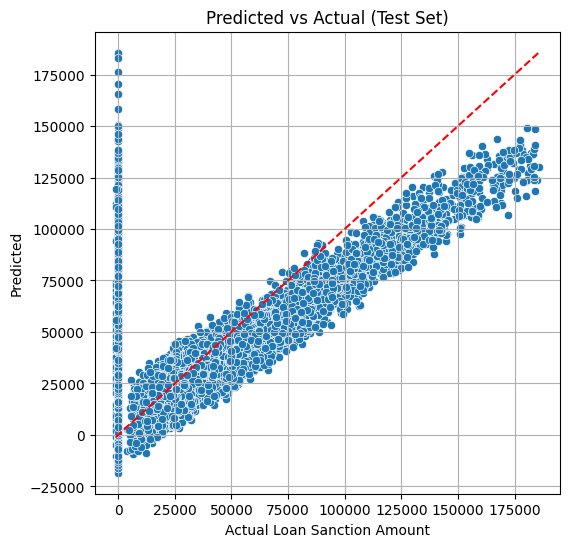

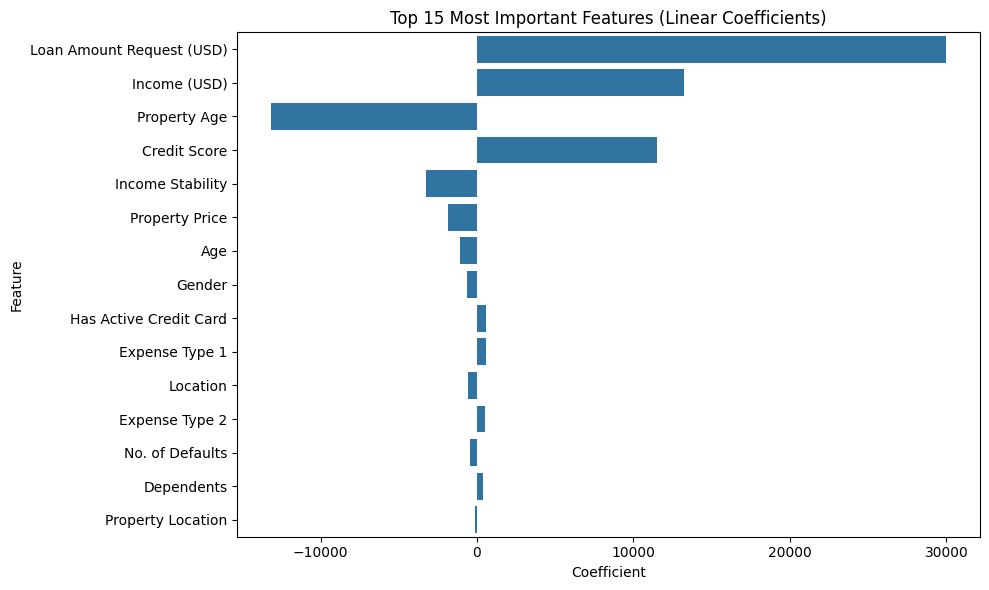

In [35]:

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Loan Sanction Amount")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Test Set)")
plt.grid(True)
plt.show()



coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df.head(15))
plt.title("Top 15 Most Important Features (Linear Coefficients)")
plt.tight_layout()
plt.show()

In [37]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {'Fold': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train_kf, y_train_kf)
    y_pred_kf = model.predict(X_test_kf)

    mae = mean_absolute_error(y_test_kf, y_pred_kf)
    mse = mean_squared_error(y_test_kf, y_pred_kf)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_kf, y_pred_kf)

    cv_results['Fold'].append(f'Fold {i+1}')
    cv_results['MAE'].append(mae)
    cv_results['MSE'].append(mse)
    cv_results['RMSE'].append(rmse)
    cv_results['R2'].append(r2)

cv_df = pd.DataFrame(cv_results)
cv_df.loc['Average'] = ['Average'] + list(cv_df.iloc[:, 1:].mean())
print(cv_df)



            Fold           MAE           MSE          RMSE        R2
0         Fold 1  21995.182202  9.739456e+08  31208.101562  0.474559
1         Fold 2  21896.121677  1.134335e+09  33679.889696  0.408176
2         Fold 3  21801.206896  9.240021e+08  30397.402732  0.519336
3         Fold 4  21493.911178  9.064092e+08  30106.629831  0.529073
4         Fold 5  21688.813708  9.133577e+08  30221.808521  0.530212
Average  Average  21775.047132  9.704099e+08  31122.766468  0.492271


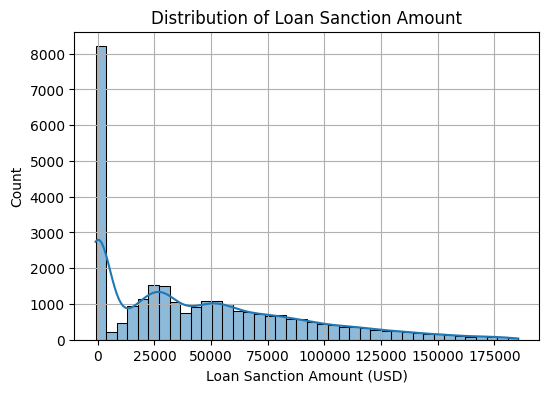

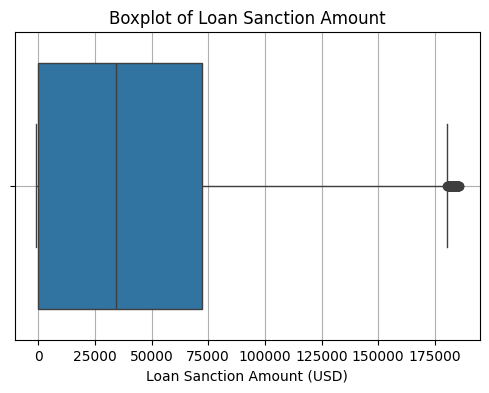

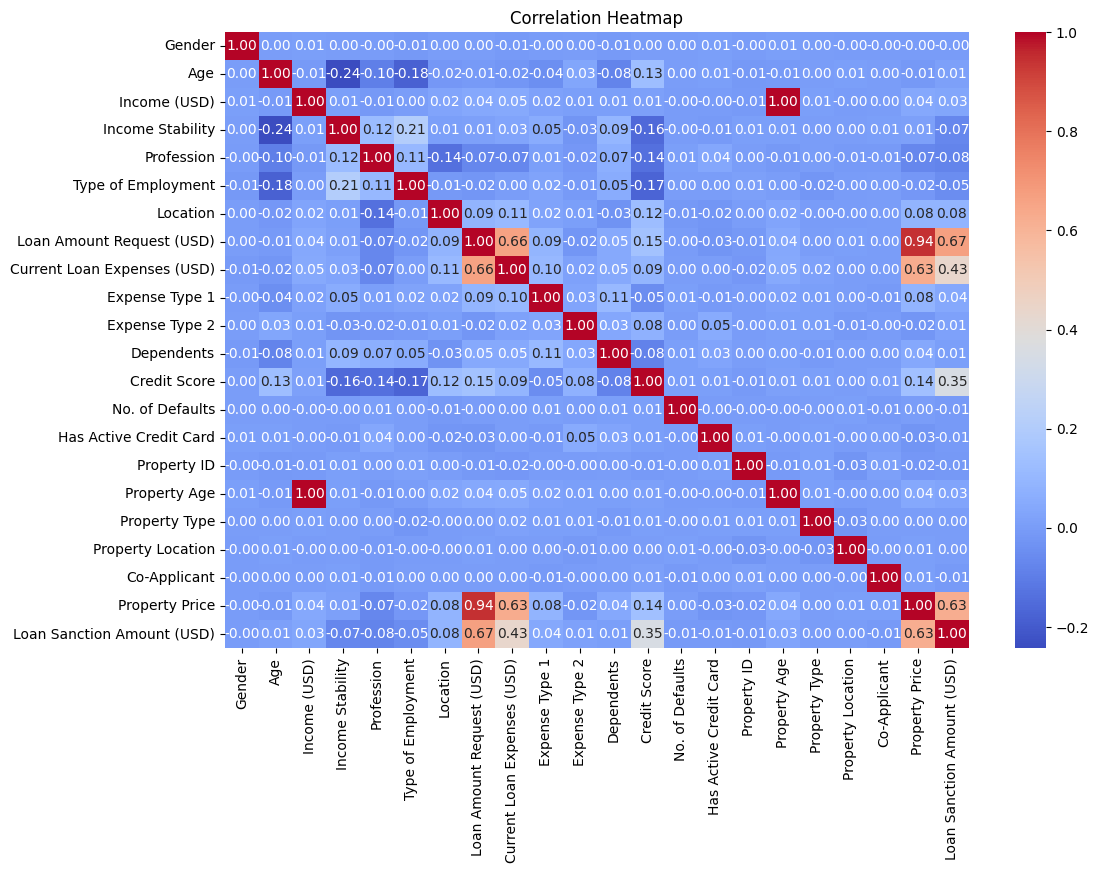

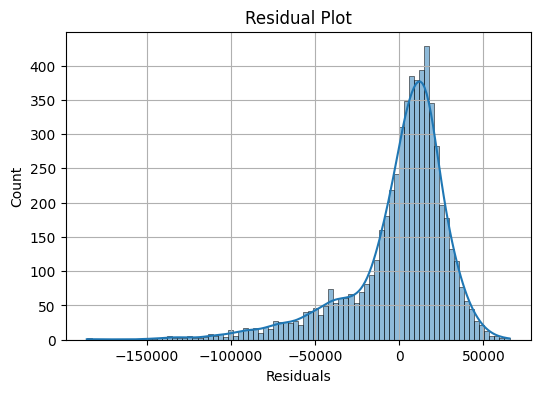

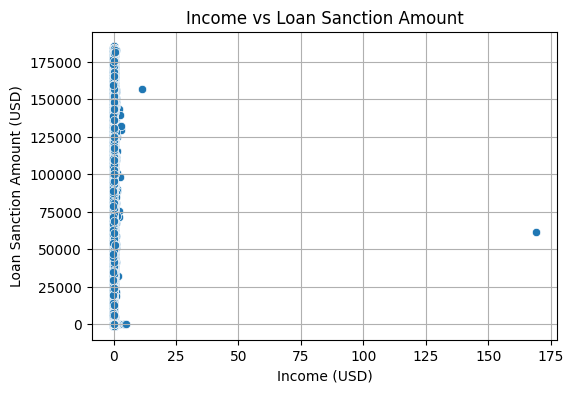

In [38]:
# Histogram of Loan Amount
plt.figure(figsize=(6,4))
sns.histplot(y, kde=True)
plt.title("Distribution of Loan Sanction Amount")
plt.grid(True)
plt.show()

# Boxplot for Loan Sanction Amount
plt.figure(figsize=(6,4))
sns.boxplot(x=y)
plt.title("Boxplot of Loan Sanction Amount")
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Residual Plot
residuals = y_test - y_pred_test
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Plot")
plt.xlabel("Residuals")
plt.grid(True)
plt.show()

# Scatter Plot: Income vs Loan Sanction Amount
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['Income (USD)'], y=df['Loan Sanction Amount (USD)'])
plt.title("Income vs Loan Sanction Amount")
plt.grid(True)
plt.show()
